In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score


In [17]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.set_index('Date', inplace=True)


In [18]:
# Step 1: Fit the ETS model
ets_model = ExponentialSmoothing(
    supply_data['Supply'], 
    trend="additive", 
    seasonal="additive", 
    seasonal_periods=7  # Weekly seasonality
).fit()

C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [19]:
# Step 2: Calculate residuals (difference between actual and ETS predictions)
supply_data['ETS_Forecast'] = ets_model.fittedvalues
supply_data['Residuals'] = supply_data['Supply'] - supply_data['ETS_Forecast']

In [20]:
# Step 3: Prepare data for Ridge Regression
# Lagged residuals as features for Ridge Regression
lags = 5  # Number of lag features to include
for lag in range(1, lags + 1):
    supply_data[f'Lag_{lag}'] = supply_data['Residuals'].shift(lag)

# Drop rows with NaN values (caused by lagging)
ridge_data = supply_data.dropna()

# Define features (lagged residuals) and target (current residuals)
X = ridge_data[[f'Lag_{lag}' for lag in range(1, lags + 1)]]
y = ridge_data['Residuals']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict residuals for the test set
ridge_predictions = ridge_model.predict(X_test)

In [21]:
# Step 4: Forecast future values using ETS + Ridge
# Forecast ETS values
future_ets = ets_model.forecast(steps=30)

# Forecast residuals using Ridge Regression (extend features into the future)
future_lags = np.array([ridge_data['Residuals'][-lags:].values]) # Use the last available lags
future_ridge_residuals = []

for _ in range(30):  # Forecast for 30 steps
    future_lags_df = pd.DataFrame(future_lags, columns=[f'Lag_{i+1}' for i in range(future_lags.shape[1])])
    pred_residual = ridge_model.predict(future_lags_df)[0]
    future_ridge_residuals.append(pred_residual)
    future_lags = np.roll(future_lags, -1)  # Shift the lags
    future_lags[0, -1] = pred_residual  # Update the last lag with the predicted residual

# Combine ETS and Ridge predictions
final_forecast = future_ets + np.array(future_ridge_residuals)

C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


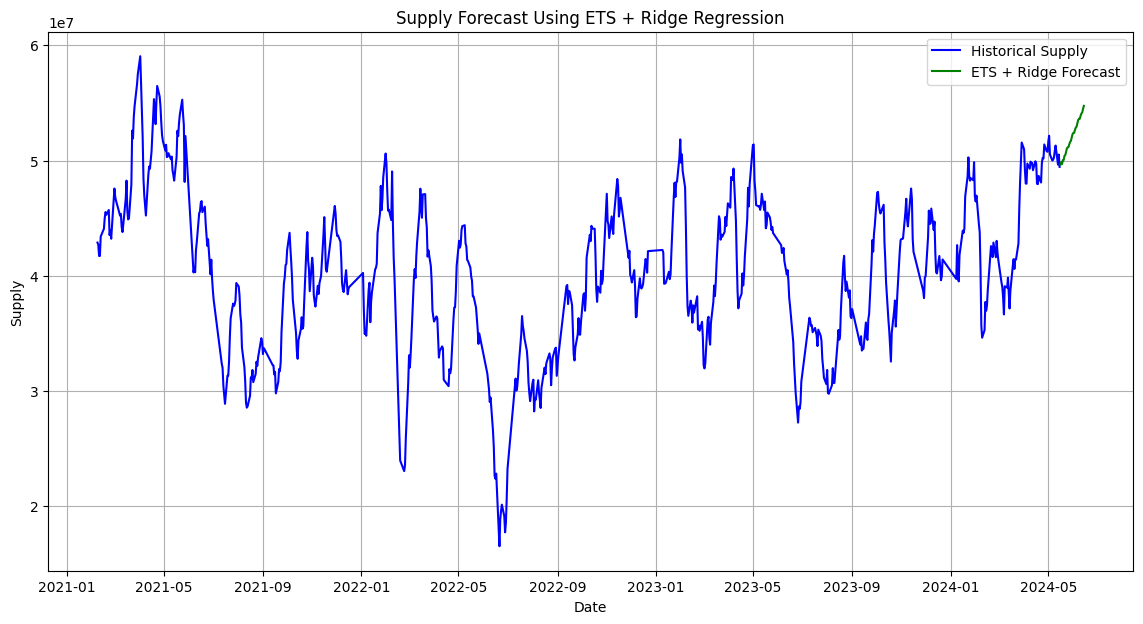

,Date,Forecasted Supply
738,2024-05-16,4.963761e+07
739,2024-05-17,4.985947e+07
740,2024-05-18,4.968787e+07
741,2024-05-19,5.002668e+07
742,2024-05-20,5.003634e+07


In [22]:
# Step 5: Plot results
forecast_index = pd.date_range(start=supply_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(forecast_index, final_forecast, label='ETS + Ridge Forecast', color='green')
plt.title('Supply Forecast Using ETS + Ridge Regression')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()

# Display the first few forecasted values
pd.DataFrame({
    "Date": forecast_index,
    "Forecasted Supply": final_forecast
}).head()